# Generative Adversarial Networks in Keras

### An improved version based on [GAN](https://arxiv.org/abs/1406.2661) and [DCGAN](https://arxiv.org/abs/1511.06434) paper

Using onehot categorical data as extra input of generative model and extra out put of discriminative model

Based on [Jeremy Howard's Note book on GAN](https://github.com/fastai/courses/blob/master/deeplearning2/dcgan.py)

In [1]:
from keras.datasets.mnist import load_data
import numpy as np
from keras.layers import Input,Dense,Dropout
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.layers import Multiply
from utils2 import plot_multi
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm,trange
from keras import backend as K

/home/zhangxiaochen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/zhangxiaochen/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
mnist=load_data()

for i in mnist[0]: print(i.shape)
for i in mnist[1]: print(i.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
train_x_,train_y_=mnist[0]
valid_x_,valid_y_=mnist[1]

# one hot encoding the labels
train_x=train_x_.reshape(-1,28*28)
valid_x=valid_x_.reshape(-1,28*28)
train_y=np.eye(10)[train_y_]
valid_y=np.eye(10)[valid_y_]

train_x.shape,train_y.shape,valid_x.shape,valid_y.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [4]:
def noise(bs):
    """
    A function to generate noise on the batch size bs
    [gipt,gipt_k]: gipt is the 100 random noise, gipt_k is the number category
    """
    return [np.random.normal(size=(bs,100)),np.eye(10)[(np.random.rand(bs)*10).astype(np.int)]]

def noise_(bs):
    """
    A function to generate noise on the batch size bs
    [gipt,gipt_k]: gipt is the 100 random noise, gipt_k is the number category
    """
    return np.random.normal(size=(bs,100))
noise_(1)

def data4D(G,sz):
    """
    Generate date for certain size(usually half of batch size), combining generated(fake) and img data(real)
    """
    idx=np.random.randint(0,len(train_x),size=sz)
    real_img=train_x[idx]
    real_label=train_y[idx]
    noi=noise(sz)
    X=np.concatenate((real_img,G.predict(noi)))
    # about soft label https://arxiv.org/abs/1606.03498
    soft_lbl=np.random.rand(sz*2)/10
    soft_lbl[sz:]+=.9
    # out put of D:0 for real, 1 for fake
    return X,[soft_lbl,np.concatenate([real_label,noi[1]])]
    # return X,[np.array([0]*sz+[1]*sz),np.concatenate([real_label,noi[1]])]
    
def bi_acc(y_true,y_pred):
    """
    binary accuracy
    """
    return K.mean(K.equal(y_true, K.round(y_pred)))

### Generative Model: G

In [ ]:
gipt=Input((100,))
gipt_k=Input((10,))
g1=Dense(200,activation="relu")(gipt)
g2=Dense(200,activation="relu")(gipt_k)
g=Multiply()([g1,g2])
g=Dense(512,activation="relu")(g)
g=Dense(28*28,activation="sigmoid")(g)
G_mlp=Model([gipt,gipt_k],g)

In [ ]:
G_mlp.summary()

In [ ]:
dipt=Input((28*28,))
d=Dense(512,activation="relu")(dipt)
d=Dense(512,activation="relu")(d)
d1=Dense(1,activation="sigmoid")(d)
d2=Dense(10,activation="softmax")(d)
D_mlp=Model(dipt,[d1,d2])
D_mlp.compile(optimizer=Adam(1e-3),loss=["binary_crossentropy","categorical_crossentropy"])

In [ ]:
D_mlp.summary()

In [ ]:
M_mlp=Model([gipt,gipt_k],D_mlp(G_mlp.output))

In [ ]:
M_mlp.compile(optimizer=Adam(1e-3),loss=["binary_crossentropy","categorical_crossentropy"])

In [ ]:
from tqdm import tqdm

In [17]:
test=data4D(G_mlp,16)

In [18]:
x,y=test

In [19]:
print(x.shape)
for i in y:
    print(i.shape)

(32, 784)
(32,)
(32, 10)


### Train Function

Train function here is based on train_on_batch

The return of noise(): noi is[a size (batchsize,100) random number,random labels]

Random labels are both used as input of G and output of D

In [20]:
def train(G,D,M,epochs=5000,bs=128):
    # Initialize 2 empety loss list
    dl=[];gl=[]
    for i in tqdm(range(epochs)):
        x,y=data4D(G,bs//2)
        # Train Discriminator D
        D.trainable = True
        for l in D.layers:l.trainable = True
        dl.append(D.train_on_batch(x,y))
        # Train Generator G by D(G(x))
        D.trainable = False
        for l in D.layers:l.trainable = False
        noi=noise(bs)
        gl.append(M.train_on_batch(noi,[np.zeros(bs),noi[1]]))
    return dl,gl

In [23]:
dl_mlp,gl_mlp=train(G_mlp,D_mlp,M_mlp)

100%|██████████| 5000/5000 [00:38<00:00, 129.44it/s]


In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

So I heard this loss doesn't mean anything...

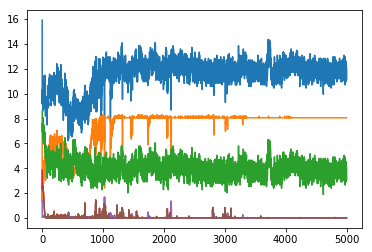

In [24]:
plt.plot(range(5000),dl_mlp,range(5000),gl_mlp)

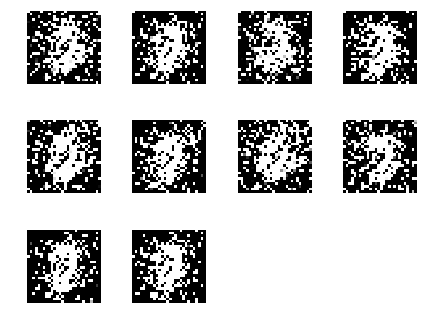

In [24]:
plot_multi(G_mlp.predict([np.random.rand(10,100),
                          np.eye(10)[np.array(range(10))]]).reshape(10,28,28), cmap='gray')

Yeah... not making much sense



### Trying Differenct Loss Function

In [ ]:
D_mlp.loss=['mae', 'categorical_crossentropy'] # mae: mean absolute error
M_mlp.loss=['mae', 'categorical_crossentropy']
for i in [D_mlp,M_mlp]:i.reset_states()

In [36]:
dl_mlp,gl_mlp=train(G_mlp,D_mlp,M_mlp,epochs=10000)

100%|██████████| 10000/10000 [03:06<00:00, 53.51it/s]


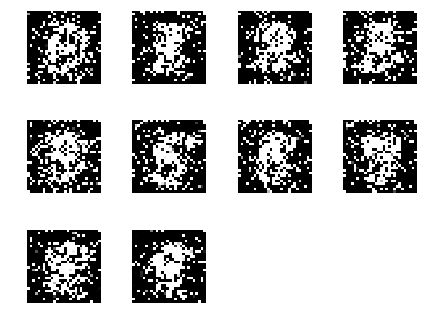

In [37]:
plot_multi(G_mlp.predict([np.random.rand(10,100),
                          np.eye(10)[np.array(range(10))]]).reshape(10,28,28), cmap='gray')

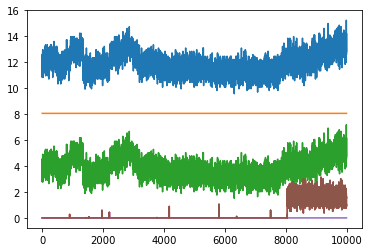

In [39]:
rg=int(1e4)
plt.plot(range(rg),dl_mlp,range(rg),gl_mlp)

Let's try to train discriminator more frequently, in the frequency 5 times more than we train Generator

In [17]:
def train(G,D,M,slower=5,epochs=5000,bs=128):
    """
    slower:the k in the 
    """
    # Initialize 2 empety loss list
    dl=[];gl=[]
    for i in tqdm(range(epochs)):
        x,y=data4D(G,bs//2)
        # Train Discriminator D
        D.trainable = True
        for l in D.layers:l.trainable = True
        dl.append(D.train_on_batch(x,y))
        # Train Generator G by D(G(x))
        if i//slower==0:
            D.trainable = False
            for l in D.layers:l.trainable = False
            noi=noise(bs)
            gl.append(M.train_on_batch(noi,[np.zeros(bs),noi[1]]))
    return dl,gl

In [ ]:
dl_mlp2,gl_mlp2=train(G_mlp,D_mlp,M_mlp)

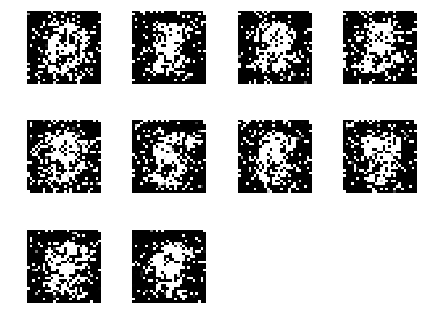

In [42]:
plot_multi(G_mlp.predict([np.random.rand(10,100),
                          np.eye(10)[np.array(range(10))]]).reshape(10,28,28), cmap='gray')

### Okay... let's move to DCGAN (Deep Convolutional GAN)

In [5]:
from keras.layers import Conv2D,UpSampling2D,Reshape,BatchNormalization,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD,Adam
from keras.layers import AveragePooling2D

def get_G(gloss="binary_crossentropy",
          last_act="sigmoid",
          opt=Adam,
          lr=1e-4,noise_size=100,
          cate_size=10):
    gipt=Input((noise_size,))
    #gipt_k=Input((cate_size,))
    
#     g1=Dense(7*7*512,activation="relu")(gipt)
#     g2=Dense(7*7*512,activation="relu")(gipt_k)
#     g=Multiply()([g1,g2])
    g=Dense(7*7*512,activation="relu")(gipt)
    g=BatchNormalization()(g)
    g=Reshape((7,7,512))(g)
    g=UpSampling2D()(g)
    g=Conv2D(64,3,strides=(1,1),padding="same",activation=LeakyReLU(alpha=0.2))(g)
#     g=Dropout(0.3)(g)
    g=UpSampling2D()(g)
    g=BatchNormalization()(g)
    g=Conv2D(32,3,strides=(1,1),padding="same",activation=LeakyReLU(alpha=0.2))(g)
#     g=Dropout(0.3)(g)
    g=BatchNormalization()(g)
    g=Conv2D(1,1,strides=(1,1),padding="same",activation=last_act)(g)

    G_dc=Model(gipt,g,name="gmodel")
#     G_dc=Model([gipt,gipt_k],g,name="gmodel")
    G_dc.compile(loss=gloss,optimizer=opt(lr))
    return G_dc

def get_D(dloss=["binary_crossentropy","categorical_crossentropy"],
          opt=Adam,
          # loss_w=[1,1e-2],
          last_act="sigmoid",
          # last_act=["sigmoid","softmax"],
          lr=1e-4,cate_size=10,ker_size=2):
    dipt=Input((28,28,1))
    d=Conv2D(128,(ker_size,ker_size),activation=LeakyReLU(0.2),padding="same")(dipt)
    d=AveragePooling2D()(d)
    d=Dropout(.3)(d)
#     d=Conv2D(128,(ker_size,ker_size),strides=2,activation=LeakyReLU(0.2),padding="same")(d)
    d=Conv2D(256,(ker_size,ker_size),activation=LeakyReLU(0.2),padding="same")(d)
    d=AveragePooling2D()(d)
#     d=Conv2D(256,(ker_size,ker_size),strides=2,activation=LeakyReLU(0.2),padding="same")(d)
#     d=Conv2D(256,(ker_size,ker_size),activation=LeakyReLU(0.2),padding="same")(d)
#     d=Conv2D(256,(ker_size,ker_size),strides=2,activation=LeakyReLU(0.2),padding="same")(d)
    d=Flatten()(d)
    d=Dense(256,activation=LeakyReLU(alpha=0.2))(d)
#     d=Dropout(.3)(d)
    # d=BatchNormalization()(d)
    d1=Dense(1,activation=last_act,name="disc_out")(d) # discriminator output
    #d1=Dense(1,activation=last_act[0],name="disc_out")(d) # discriminator output
    # d2=Dense(cate_size,activation=last_act[1],name="cls_out")(d) # classifier output
    #D_dc=Model(dipt,[d1,d2],name="dmodel")
    D_dc=Model(dipt,d1,name="dmodel")
    
    D_dc.compile(
                    #loss_weights=loss_w,
#                  metrics={"disc_out":"accuracy","cls_out":"accuracy"},
                 metrics=["accuracy"],
                 loss=dloss,optimizer=opt(lr,
                                           #beta_1=.5
                                          ))
    return D_dc

# D_dc.summary()

def get_GDM(lr=1e-4,ker_size=2,
            opt=Adam,
            gloss="binary_crossentropy",
            dloss="binary_crossentropy",
            # dloss=["binary_crossentropy","categorical_crossentropy"],
          # loss_w=[1,1e-2],
            act_last="sigmoid",
            #act_cate="softmax"
           ):
    """
    Combine G & D into M
    """
    G_dc=get_G(lr=lr,opt=Adam,
               last_act=act_last)
    D_dc=get_D(lr=lr,ker_size=ker_size,
               opt=opt,
               dloss=dloss,
               #loss_w=loss_w,
               last_act=act_last)
               # last_act=[act_last,act_cate])
    M_dc=Model(G_dc.input,D_dc(G_dc.output),name="gdmodel")
    M_dc.compile(
                # loss_weights=loss_w,
                 metrics=[bi_acc],
#                  metrics={M_dc.layers[-1].output_layers[0]:"mse",
#                           M_dc.layers[-1].output_layers[1]:"mse"},
                 optimizer=opt(lr),loss=dloss)
    return G_dc,D_dc,M_dc

M=D(G(x))

as training G use D as a part of the loss function

In [7]:
sz=128
soft_lbl=np.random.rand(sz*2)/10
soft_lbl[sz:]+=.9
soft_lbl

array([0.03782693, 0.03738937, 0.00935341, 0.08146972, 0.04258209,
       0.08289236, 0.02489555, 0.0013712 , 0.04755096, 0.09543438,
       0.03983997, 0.0165521 , 0.05934914, 0.03719633, 0.03524623,
       0.06667229, 0.003838  , 0.06005622, 0.07101093, 0.06514255, ...,
       0.98962335, 0.91754738, 0.98940052, 0.95476542, 0.9086017 ,
       0.92904939, 0.97943674, 0.92767659, 0.96502905, 0.99941271,
       0.93372287, 0.92228011, 0.9009916 , 0.93182716, 0.96023462,
       0.95501524, 0.97145004, 0.92523177, 0.95217412, 0.98123873])

In [8]:
def data4D(G,sz):
    """
    Generate date for certain size(usually half of batch size), combining generated(fake) and img data(real)
    """
    idx=np.random.randint(0,len(train_x),size=sz)
    real_img=train_x[idx].reshape(sz,28,28,1)/127-2
    real_label=train_y[idx]
    noi=noise(sz)
    X=np.concatenate((real_img,G.predict(noi)))
#     soft_lbl=np.random.rand(sz*2)/10
#     soft_lbl[sz:]+=.9
    # out put of D:0 for real, 1 for fake
    return X,[np.array([0]*sz+[1]*sz),np.concatenate([real_label,noi[1]])]

def data4D_(G,sz):
    """
    Generate date for certain size(usually half of batch size), combining generated(fake) and img data(real)
    """
    idx=np.random.randint(0,len(train_x),size=sz)
    real_img=train_x[idx].reshape(sz,28,28,1)/127-2
    # real_label=train_y[idx]
    noi=noise_(sz)
    X=np.concatenate((real_img,G.predict(noi)))
#     soft_lbl=np.random.rand(sz*2)/10
#     soft_lbl[sz:]+=.9
    # out put of D:0 for real, 1 for fake
    return X,np.array([0]*sz+[1]*sz)

def train(G,D,M,lr=1e-4,reset_lr=True,train_cls=True,d_head=300,slower=5,epochs_cls=1,epochs=5000,bs=128):
    """
    G:Generative Model
    D:Dsicriminative Model
    M:D(G(x))
    d_head: head start of Discriminative Model D
    slower: how slower you want to train G, compare to D
    epochs: epochs of training
    bs: batch_size
    """
    # Initialize 2 empety loss list
    dl=[];gl=[]
    if train_cls:
        print("Train D as classifier first")
        lw=D.loss_weights
        D.loss_weights=[1e-6,1]
        D.fit(train_x_.reshape(-1,28,28,1),[np.zeros(train_y.shape[0]),train_y],epochs=epochs_cls,batch_size=bs)
        D.loss_weights=lw
        M.loss_weights=lw
    print("Start training GAN")
    for i in tqdm(range(epochs)):
        x,y=data4D(G,bs//2)
        # Train Discriminator D
        D.trainable = True
        for l in D.layers:l.trainable = True
        dl.append(D.train_on_batch(x,y))
        # Train Generator G by D(G(x))
        if i>d_head and i%slower==0:
            D.trainable = False
            for l in D.layers:l.trainable = False
            noi=noise(bs)
            gl.append(M.train_on_batch(noi,[np.zeros(bs),noi[1]]))
        if i%300==0:
            if reset_lr:
                for md in [D,G,M]:md.optimizer.lr=1e-4
            plot_multi(G.predict([np.random.rand(10,100),
                      np.eye(10)[np.array(range(10))]]).reshape(10,28,28), cmap='gray')
    return dl,gl

from math import exp
def lw_exp(x):
    return 1.0/(1.0-exp(-x-0.001))

def train_saw_(G,D,M,lr=2e-4,
              badge=.8,
              train_cls=True,
              epochs_cls=1,
                d2m_lr=1e-1,
               lead=300,
              epochs=5000,
              bs=128):
    """
    G:Generative Model
    D:Dsicriminative Model
    M:D(G(x))
    badge:the badge value, how god should a D be, we will train a G
    epochs: epochs of training
    bs: batch_size
    """
    # Initialize 2 empety loss list
    lgan=[]
    train_type=[]
#     if train_cls:
#         print("Train D as classifier first")
#         lw=D.loss_weights
#         D.loss_weights=[0,1]
#         D.fit(train_x_.reshape(-1,28,28,1),[np.zeros(train_y.shape[0]),train_y],epochs=epochs_cls,batch_size=bs)
#         D.loss_weights=lw
#         M.loss_weights=lw
    
    
    w=trange(lead)
    for i in w:
        x,y=data4D_(G,bs//2)
        D.optimizer.lr=lr
        lgan.append(D.train_on_batch(x,y))
        train_type.append("D")
        w.set_postfix(g_per="%.1f"%(train_type[-100:].count("G")*100/len(train_type[-100:])),# persentage of G in last 100 steps
                    last=train_type[-1],
                      dis_acc="%.1f"%(100*lgan[-1][-1])
                     )
    print("Start training GAN")
    t=trange(epochs)
    for i in t:
        # for md in [D,M]:md.loss_weights=[lw_exp(lgan[-1][-2]),lw_exp(lgan[-1][-1])]
        if (train_type[-1]=="D" and lgan[-1][-1]<badge) or (train_type[-1]=="G" and lgan[-1][-1]>badge):
            x,y=data4D_(G,bs//2)
            D.optimizer.lr=lr
            # Train Discriminator D
            D.trainable = True
            for l in D.layers:l.trainable = True
            lgan.append(D.train_on_batch(x,y))
            train_type.append("D")
        else:
            M.optimizer.lr=lr*d2m_lr
            # Train Generator G by D(G(x))
            D.trainable = False
            for l in D.layers:l.trainable = False
            noi=noise_(bs)
            lgan.append(M.train_on_batch(noi,
                                         np.zeros(bs),
#                                          [np.zeros(bs),noi[1]]
                                        )
                       )
            train_type.append("G")
        t.set_postfix(g_per="%.1f"%(train_type[-100:].count("G")*100/len(train_type[-100:])),# persentage of G in last 100 steps
                    last=train_type[-1],
                      dis_acc="%.1f"%(100*lgan[-1][-1]),
                      loss="%.6f"%(100*lgan[-1][0]),
#                       cls_acc="%.1f"%(100*lgan[-1][-1]),
#                       lw_dis=D.loss_weights[0],
#                       lw_cls=D.loss_weights[1],
                     )
        if i%300==0:
            plot_multi(G.predict(
#                 [
                    np.random.rand(10,100),
#                       np.eye(10)[np.array(range(10))]]
            ).reshape(10,28,28), cmap='gray')
    return lgan,train_type


In [9]:
G_dc,D_dc,M_dc=get_GDM(opt=Adam,
                       gloss="binary_crossentropy",
                        dloss="binary_crossentropy",
#                         dloss=["binary_crossentropy","categorical_crossentropy"],
                       ker_size=3,
                      # loss_w=[1,1]
                      )

/home/zhangxiaochen/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [10]:
D_dc=get_D(ker_size=3,dloss="binary_crossentropy",opt=Adam,)

/home/zhangxiaochen/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


  0%|          | 0/2000 [00:00<?, ?it/s]

Start training GAN


100%|██████████| 2000/2000 [01:58<00:00, 16.94it/s, dis_acc=100.0, g_per=50.0, last=G, loss=0.000057]


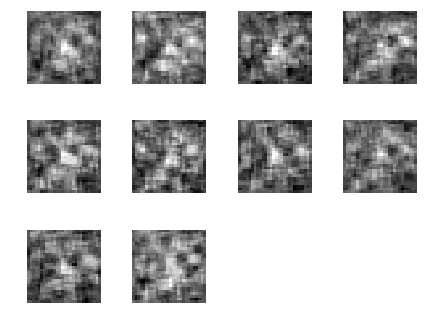

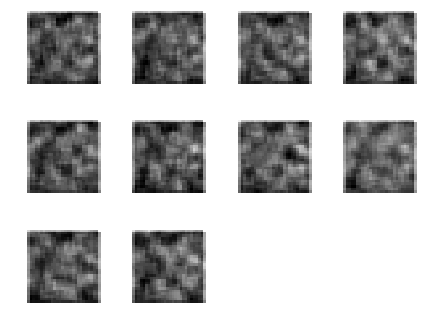

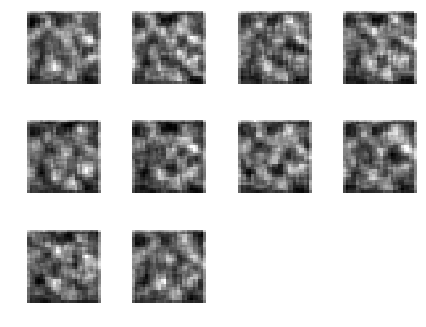

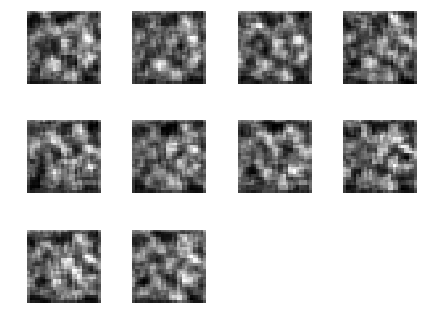

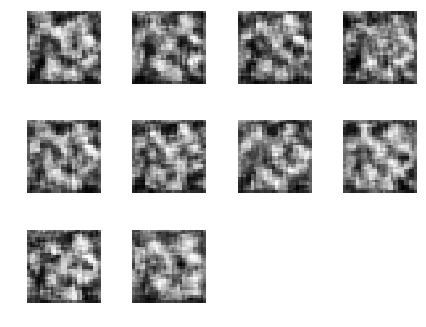

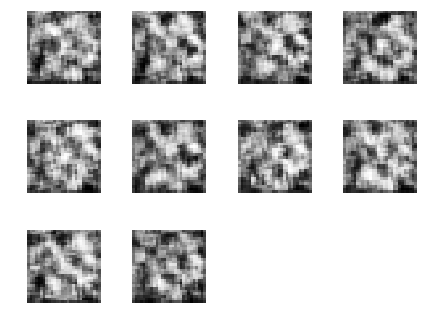

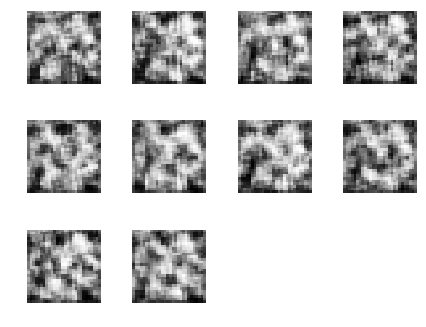

In [11]:
##### dl_dc,gl_dc=train(G_dc,D_dc,M_dc,train_cls=False,
#                   d_head=200,
#                   slower=5,
#                   epochs=2500,
#                   bs=256,)
loss_dc,GvsD_dc=train_saw_(G_dc,
                          D_dc,
                          M_dc,
                          lr=1e-5,
                           d2m_lr=10,
                           lead=100,
                          train_cls=True,
                          badge=.9,
                          epochs=2000,
                          bs=128,)

In [20]:
loss_dc[-100:],GvsD_dc[-100:]



([[1.0000002e-07, 1.0],
  [1.221466e-05, 1.0],
  [1.0000002e-07, 1.0],
  [1.0063601e-05, 1.0],
  [1.0000002e-07, 1.0],
  [8.3338982e-06, 1.0],
  [1.0000002e-07, 1.0],
  [1.1535196e-05, 1.0],
  [1.0000002e-07, 1.0],
  [8.8690867e-06, 1.0],
  [1.0000002e-07, 1.0],
  [9.244739e-06, 1.0],
  [1.0000002e-07, 1.0],
  [8.1264188e-06, 1.0],
  [1.0000002e-07, 1.0],
  [1.1465554e-05, 1.0],
  [1.0000002e-07, 1.0],
  [1.1574531e-05, 1.0],
  [1.0000002e-07, 1.0],
  [9.6637232e-06, 1.0],
  [1.0000002e-07, 1.0],
  [8.393753e-06, 1.0],
  [1.0000002e-07, 1.0],
  [1.0385367e-05, 1.0],
  [1.0000002e-07, 1.0],
  [1.1239598e-05, 1.0],
  [1.0000002e-07, 1.0],
  [1.3263561e-05, 1.0],
  [1.0000002e-07, 1.0],
  [8.4066696e-06, 1.0],
  [1.0000002e-07, 1.0],
  [1.0990641e-05, 1.0],
  [1.0000002e-07, 1.0],
  [1.2218596e-05, 1.0],
  [1.0000002e-07, 1.0],
  [1.1145195e-05, 1.0],
  [1.0000002e-07, 1.0],
  [1.0915753e-05, 1.0],
  [1.0000002e-07, 1.0],
  [1.165412e-05, 1.0],
  [1.0000002e-07, 1.0],
  [8.2846336e-06, 1.

In [29]:
M_dc.metrics_names

['loss', 'dmodel_loss', 'dmodel_loss', 'dmodel_acc', 'dmodel_acc']

In [99]:
Model(G_dc.input,D_dc(G_dc.output),name="gdmodel").output

[<tf.Tensor 'dmodel_22/disc_out/Sigmoid:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dmodel_22/cls_out/Softmax:0' shape=(?, 10) dtype=float32>]

In [93]:
def testgd(G,D,M):
    x,y=data4D_(G,32//2)
    # Train Discriminator D
    D.trainable = True
    for l in D.layers:l.trainable = True
    ddict = dict((k,v) for k,v in zip(D.metrics_names,D.evaluate(x,y)))
    inf_d = D.predict(x)
    D.trainable = False
    for l in D.layers:l.trainable = False
    noi=noise_(32)
    mdict = dict((k,v) for k,v in zip(M.metrics_names,M.evaluate(noi,np.zeros(32),)))
    inf_m = M.predict(noi)
    return ddict, mdict ,inf_d,len(np.zeros(32)),np.round(inf_m)

In [94]:
from keras.metrics import binary_accuracy
M_dc.metrics=[bi_acc]


In [95]:
testgd(G_dc,D_dc,M_dc)

32/32 [==============================] - 0s


({'acc': 1.0, 'loss': 0.013372402638196945},
 {'acc': 0.0, 'loss': 3.6276662349700928},
 array([[  4.81866607e-07],
        [  3.47945189e-07],
        [  5.56266059e-07],
        [  6.05969944e-07],
        [  1.34169909e-07],
        [  8.36717930e-08],
        [  6.01051909e-07],
        [  1.12345361e-07],
        [  9.99694635e-07],
        [  3.45198032e-06],
        [  3.69826608e-07],
        [  1.91681394e-07],
        [  2.42356975e-07],
        [  1.61923950e-07],
        [  5.94998482e-07],
        [  1.46976760e-07],
        [  9.70808208e-01],
        [  9.71666873e-01],
        [  9.70864356e-01],
        [  9.74046469e-01],
        [  9.76767838e-01],
        [  9.74742174e-01],
        [  9.73903179e-01],
        [  9.71898675e-01],
        [  9.75868225e-01],
        [  9.74892497e-01],
        [  9.74696815e-01],
        [  9.76996720e-01],
        [  9.74333286e-01],
        [  9.70135212e-01],
        [  9.73492563e-01],
        [  9.72684622e-01]], dtype=float32),

In [20]:
.name

'disc_out'

In [77]:
def bi_acc(y_true,y_pred):
    """
    binary accuracy
    """
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [27]:
def plot_G(G):
    plot_multi(G.predict([np.random.rand(10,100),
                          np.eye(10)[np.array(range(10))]]).reshape(10,28,28), cmap='gray')

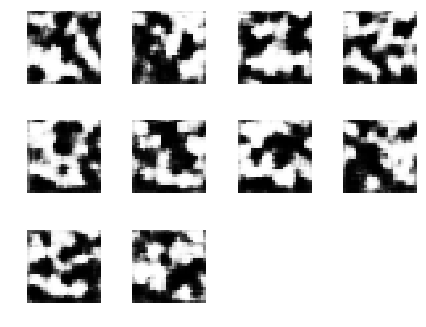

In [35]:
plot_G(G_dc)

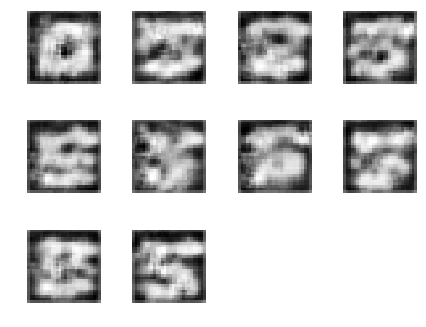

In [16]:
plot_G(G_dc)

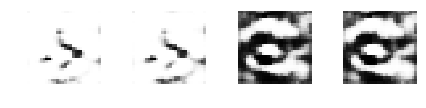

In [29]:
plot_multi(G_dc.predict([np.random.rand(4,100),
                          np.eye(10)[np.array([2,2,3,3])]+np.eye(10)[np.array([1,1,2,2])]]).reshape(4,28,28), cmap='gray')

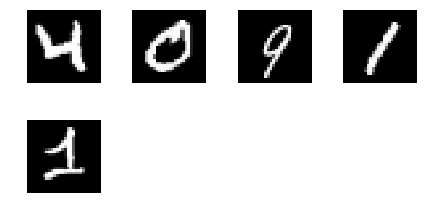

In [55]:
plot_multi(train_x[20:25].reshape(-1,28,28)/256, cmap='gray')

In [51]:
train_x[:5].reshape(-1,28,28)/255

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.  